In [38]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb
import tensorflow as tf

In [ ]:
pred_rf = pd.read_csv('submit/submit_RF22_2244.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost17_1208.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id, 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [ ]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(10)id

In [ ]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [ ]:
pred['pred'] = (pred.RandomForest * 0.04 + pred.XGBoost * 0.03 + pred.NN * 0.03
                + pred.LightGBM * 0.35 + pred.CatBoost * 0.55)
pred.head()

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred['id'],
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

# LogisticRegression

In [2]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [3]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']

In [4]:
rf_model = pickle.load(open('models/RF_22_2248.pkl', 'rb'))
xgb_model = pickle.load(open('models/XG_17_1144.pkl', 'rb'))
lgb_model = pickle.load(open('models/LGBM_op24_0418.pkl', 'rb'))

In [5]:
f_rf = rf_model.predict_proba(x)
first_rf = pd.DataFrame(f_rf)

f_xgb = xgb_model.predict_proba(x)
first_xgb = pd.DataFrame(f_xgb)

f_lgb = lgb_model.predict(x)
first_lgb = pd.DataFrame(f_lgb)

first_pred = np.column_stack((first_rf[1],first_xgb[1], first_lgb[0]))
train_pred = pd.DataFrame(first_pred, columns=('RF', 'XGB', 'LGB'))

train_pred = pd.concat([ID, train_pred, y], axis=1)
train_pred['id'] = [int(i) for i in train_pred['id']]
train_pred.head(-10)

,id,RF,XGB,LGB,y
0,0,0.019764,0.000207,0.041840,0
1,1,0.178051,0.845551,0.178831,1
2,2,0.010521,0.000607,0.036251,0
3,3,0.014289,0.000238,0.040736,0
4,4,0.186455,0.004137,0.118117,0
...,...,...,...,...,...
27085,27085,0.025268,0.000278,0.046788,0
27086,27086,0.023498,0.000030,0.041830,0
27087,27087,0.044049,0.002026,0.051748,0
27088,27088,0.141111,0.091323,0.114841,0


In [6]:
del train_df, test_df, ID, x, y

In [7]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [8]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])

In [9]:
cb_model = pickle.load(open('models/CatBoost_24_0835.pkl', 'rb'))

In [10]:
f_cb = cb_model.predict_proba(x)
first_cb = pd.DataFrame(f_cb)

tmp_train_pred = pd.concat([ID, first_cb[1]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,1
0,0,0.005982
1,1,0.174154
2,2,0.006766
3,3,0.004269
4,4,0.148330
...,...,...
27085,27085,0.011141
27086,27086,0.003571
27087,27087,0.017806
27088,27088,0.182574


In [20]:
tr_pred = pd.merge(train_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={1: 'CB'})

(27100, 6)

In [ ]:
"""
NNモデル追加
"""

In [21]:
col = ['id', 'RF', 'XGB', 'LGB', 'CB', 'NN', 'y']
tr_pred = tr_pred.reindex(col, axis=1)

del col
tr_pred.head(-10)

,id,RF,XGB,LGB,CB,y
0,0,0.019764,0.000207,0.041840,0.005982,0
1,1,0.178051,0.845551,0.178831,0.174154,1
2,2,0.010521,0.000607,0.036251,0.006766,0
3,3,0.014289,0.000238,0.040736,0.004269,0
4,4,0.186455,0.004137,0.118117,0.148330,0
...,...,...,...,...,...,...
27085,27085,0.025268,0.000278,0.046788,0.011141,0
27086,27086,0.023498,0.000030,0.041830,0.003571,0
27087,27087,0.044049,0.002026,0.051748,0.017806,0
27088,27088,0.141111,0.091323,0.114841,0.182574,0


In [24]:
del train_df, test_df, ID, x
gc.collect()

2449

In [34]:
x = tr_pred.iloc[:, 1:5]
y = tr_pred['y']
ID = tr_pred['id']

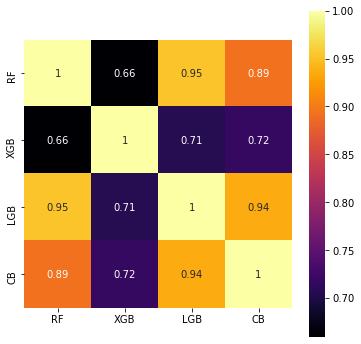

In [31]:
corr = x.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [39]:
lr_model = LogisticRegression()
lr_model.fit(x, y)

LogisticRegression()

In [48]:
lr_p.shape

(27100, 2)

In [50]:
lr_p = lr_model.predict_proba(x)
p_lr = pd.DataFrame(lr_p)

lr_pred = pd.DataFrame({
    'id':ID,
    'logistic': p_lr[1]
})

In [51]:
train_pred_df = pd.merge(tr_pred, lr_pred, on='id')
train_pred_df.head(-10)

,id,RF,XGB,LGB,CB,y,logistic
0,0,0.019764,0.000207,0.041840,0.005982,0,0.008872
1,1,0.178051,0.845551,0.178831,0.174154,1,0.986398
2,2,0.010521,0.000607,0.036251,0.006766,0,0.008870
3,3,0.014289,0.000238,0.040736,0.004269,0,0.008862
4,4,0.186455,0.004137,0.118117,0.148330,0,0.010982
...,...,...,...,...,...,...,...
27085,27085,0.025268,0.000278,0.046788,0.011141,0,0.008961
27086,27086,0.023498,0.000030,0.041830,0.003571,0,0.008830
27087,27087,0.044049,0.002026,0.051748,0.017806,0,0.009188
27088,27088,0.141111,0.091323,0.114841,0.182574,0,0.027504


In [62]:
pred_rf = pd.read_csv('submit/submit_RF22_2244.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost17_1208.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id', 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [63]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(-10)

,id,RandomForest,XGBoost,LightGBM,CatBoost
0,0,0.653176,0.850221,0.359419,0.874176
1,1,0.074268,0.136567,0.092231,0.055457
2,2,0.039741,0.001006,0.050437,0.024032
3,3,0.002598,0.000054,0.035582,0.003217
4,4,0.092913,0.002854,0.071720,0.042077
...,...,...,...,...,...
18035,18035,0.076255,0.013287,0.078328,0.037572
18036,18036,0.054682,0.071169,0.077653,0.066366
18037,18037,0.001582,0.000357,0.034496,0.002404
18038,18038,0.030693,0.000552,0.053604,0.030467


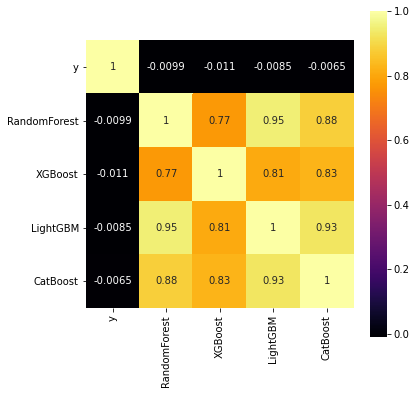

In [58]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [59]:
del x, y
gc.collect()

In [64]:
x = pred.iloc[:, 1:]
ID = pred['id']

In [65]:
reg_p = lr_model.predict_proba(x)

p_reg = pd.DataFrame(reg_p)

reg_pred = pd.DataFrame({
    'id':ID,
    'logistic': p_reg[1]
})

In [66]:
pred_df = pd.merge(pred, reg_pred, on='id')
pred_df.head(-10)

,id,RandomForest,XGBoost,LightGBM,CatBoost,logistic
0,0,0.653176,0.850221,0.359419,0.874176,0.993472
1,1,0.074268,0.136567,0.092231,0.055457,0.038562
2,2,0.039741,0.001006,0.050437,0.024032,0.009134
3,3,0.002598,0.000054,0.035582,0.003217,0.008805
4,4,0.092913,0.002854,0.071720,0.042077,0.009582
...,...,...,...,...,...,...
18035,18035,0.076255,0.013287,0.078328,0.037572,0.010755
18036,18036,0.054682,0.071169,0.077653,0.066366,0.019918
18037,18037,0.001582,0.000357,0.034496,0.002404,0.008816
18038,18038,0.030693,0.000552,0.053604,0.030467,0.009197


In [ ]:
pred['pred'] = (pred.RandomForest * 0.04 + pred.XGBoost * 0.03 + pred.NN * 0.03
                + pred.LightGBM * 0.35 + pred.CatBoost * 0.55)
pred.head()

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred['id'],
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)